# Visualize Protein Latent Space

This notebook will explore global semantic meaning in proteins. Using ESM-2 embeddings to visualize protein space is a staple of modern bioinformatics.

## Step 1. Download protein data with sequence and  location labels

We’ll use the requests library to pull live data from UniProt. We will target two very distinct protein classes to ensure the "Latent Space" clustering is obvious:
* G Protein-Coupled Receptors (GPCRs): These sit in the cell membrane.
* Cytochrome P450 Enzymes: These are metabolic enzymes.

The data acquisition script fetches 250 sequences of each type directly from the UniProt REST API.

In [1]:
import requests
import pandas as pd
import io

def fetch_uniprot_data(query, limit=250, label=""):
    url = f"https://rest.uniprot.org/uniprotkb/search?query={query}&format=tsv&fields=accession,sequence,protein_name&size={limit}"
    response = requests.get(url)
    df = pd.read_csv(io.StringIO(response.text), sep='\t')
    df['label'] = label
    return df

# Fetching two distinct groups
gpcr_df = fetch_uniprot_data("family:\"g-protein coupled receptor 1\"", label="GPCR")
enzyme_df = fetch_uniprot_data("family:\"cytochrome p450\"", label="Enzyme")

# Combine and shuffle
df = pd.concat([gpcr_df, enzyme_df]).sample(frac=1).reset_index(drop=True)
print(f"Dataset loaded: {len(df)} proteins.")
df.head()

Dataset loaded: 500 proteins.


,Entry,Sequence,Protein names,label
0,O43174,MGLPALLASALCTFVLPLLLFLAAIKLWDLYCVSGRDRSCALPLPP...,Cytochrome P450 26A1 (CYP26A1) (EC 1.14.13.-) ...,Enzyme
1,P30936,MAAVTYPSSVPTTLDPGNASSAWPLDTSLGNASAGTSLAGLAVSGI...,Somatostatin receptor type 3 (SS-3-R) (SS3-R) ...,GPCR
2,P29371,MATLPAAETWIDGGGGVGADAVNLTASLAAGAATGAVETGWLQLLD...,Neuromedin-K receptor (NKR) (NK-3 receptor) (N...,GPCR
3,Q9DBG1,MAAWSRTRLRWTLLDPRVVGRGLCPQGARAKATIPAALQAQESTEG...,"Sterol 26-hydroxylase, mitochondrial (EC 1.14....",Enzyme
4,Q9NR63,MLFEGLDLVSALATLAACLVSVTLLLAVSQQLWQLRWAATRDKSCK...,Cytochrome P450 26B1 (EC 1.14.13.-) (Cytochrom...,Enzyme


## Step 2. Extract ESM-2 Embeddings
We will use the smallest ESM-2 model `esm2_t6_8M` (6 layers, 8M parameters). It is fast enough to run on a standard laptop CPU in a few minutes.
### 3.1 Install transformer
We will use the `transformers` library, instead of the native `fair-esm` in the previous notebook to handle embeddings, because it is athe industry standard for NLP/LLMs. If you learn this, you can easilyt switch from ESM-2 to other models using the exact same code structure

In [2]:
# !pip install transformers

### 3.2 Breaking down of `get_embeddings` method:
#### Model state management  `model.eval()` 
* What it does: This switches the model into "Evaluation Mode."
* Why it's needed: Transformer models like ESM-2 use Dropout (which randomly turns off neurons to prevent overfitting during training). If you don't call .eval(), your embeddings will be "noisy" and slightly different every time you run them because the neurons are still randomly flickering. .eval() ensures the output is **deterministic **.

#### Tokenization & Numerical Prep

```
inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=1024)
```
* `return_tensors="pt"`: Tells the tokenizer to return Pytorch tensors (instead of Python lists or NumPy arrays).
* ``truncation=True`: ensures when a sequence is longer than `max_length`, the tokenizer will snip it so that the code keeps running
* `padding=True` & : Ensures that if you were doing batches, they would all be the same length, so NOT needed for processing one sequence at a time, it is more future-proof


#### "Latent Space" extraction (Mean Pooling)

```
mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
```

* `outputs.last_hidden_state`: This is a 3D tensor of shape [1, sequence_length, 320].

  * 1: The batch size (we are doing 1 protein at a time).

  * sequence_length: Every amino acid in your protein gets its own 320-dimensional vector.

  * 320: The number of features learned by ESM-2.

* `.mean(dim=1`)`: We calculate the average of all amino acid vectors. This collapses the sequence_length dimension. Analogy: If a protein is a sentence, this is like taking the average "meaning" of every word to get the "meaning" of the whole paragraph.

* `.squeeze().numpy()`: We remove the empty "batch" dimension and convert the PyTorch tensor into a standard NumPy array so scikit-learn (t-SNE) can use it.


In [ ]:
from transformers import AutoTokenizer, EsmModel
import torch
from tqdm import tqdm
import numpy as np

# Load model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name)

def get_embeddings(sequences):
    model.eval()
    embeddings = []
    # Loop through each sequence and extract its embedding -> this is the bottleneck of the code, it can be sped up by batching sequences together, but for simplicity we will do it one by one here, I tried batching but it is very memory intensive and can cause out of memory errors on a laptop CPU, so I will leave it as an exercise for the reader to optimize this part
    for seq in tqdm(sequences, desc="Extracting Embeddings"): # tqdm is a progress bar library to show progress when processing many sequences
        inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=1024)
        with torch.no_grad():  # disable gradient calculation for efficiency
            outputs = model(**inputs)
        
        # Mean Pooling: Average all amino acid vectors to get one protein vector
        # outputs.last_hidden_state shape: [1, sequence_length, hidden_dimension]
        mean_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(mean_embedding)
        
    return np.array(embeddings)

protein_embeddings = get_embeddings(df['Sequence'].tolist())

Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

EsmModel LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
pooler.dense.weight         | MISSING    | 
pooler.dense.bias           | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
Extracting Embeddings: 100%|██████████| 500/500 [00:59<00:00,  8.38it/s]


## Step 3. t-SNE vs. UMAP
t-SNE and UMAP are different ways to visualize high-dimensional data.

The high-quality clustering validates that the Mean Pooling of ESM-2 embeddings successfully aggregates global sequence-level information into a functional "fingerprint." t-SNE provides a clear, distinct separation ideal for "categorical" visualization, whereas UMAP offers a more computationally efficient projection that better reflects the overarching topology of the protein universe.

|Feature|t-SNE (t-Distributed Stochastic Neighbor Embedding)|UMAP (Uniform Manifold Approximation & Projection)|
|-------|---------------------------------------------------|--------------------------------------------------|
|Primary Focus|Local Structure: It prioritizes keeping near-neighbors together.|Balance: It aims to preserve both local clusters and the global manifold shape.|
Mathematical Basis|Minimizes KL-Divergence between probability distributions of distances.|Uses Riemannian Geometry and fuzzy simplicial sets.
|Inter-cluster Distance|Non-meaningful: The distance between the GPCR island and the Enzyme island is largely arbitrary.|Partially Meaningful: The relative positions of clusters often reflect broader evolutionary relationships.|
|Clumpiness|Tends to create very dense| circular clusters.|Often produces stringy or more complex shapes that may reveal sub-families.|

In [4]:
# install umap-learn for dimensionality reduction
# !conda install -c conda-forge umap-learn

Text(0.5, 1.0, 'UMAP Visualization')

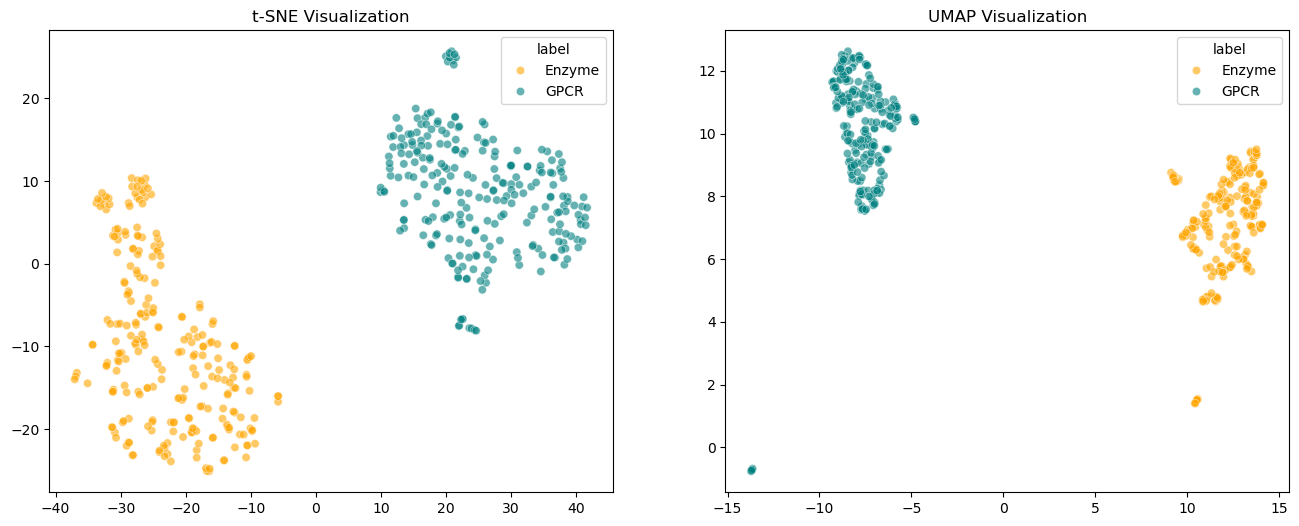

In [12]:
from sklearn.manifold import TSNE
import umap  # You might need to 'pip install umap-learn'
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute t-SNE
tsne_results = TSNE(n_components=2, perplexity=30).fit_transform(protein_embeddings)

# 2. Compute UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
umap_results = reducer.fit_transform(protein_embeddings)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = {'GPCR': 'teal', 'Enzyme': 'orange'}
label_colors = df['label'].map(colors)

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df['label'], palette=colors, alpha=0.6, ax=ax1)


ax1.set_title("t-SNE Visualization")
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=df['label'], palette=colors, alpha=0.6, ax=ax2)

ax2.set_title("UMAP Visualization")


